<a href="https://colab.research.google.com/github/JG-geek/Diffusion_Models/blob/main/blurred_conditioned_diffusion_model_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making a Class-Conditioned Diffusion Model

In this notebook we're going to illustrate one way to add conditioning information to a diffusion model. Specifically, we'll train a class-conditioned diffusion model on MNIST following on from the ['from-scratch' example in Unit 1](https://github.com/huggingface/diffusion-models-class/blob/unit2/unit1/02_diffusion_models_from_scratch.ipynb), where we can specify which digit we'd like the model to generate at inference time.

As mentioned in the introduction to this unit, this is just one of many ways we could add additional conditioning information to a diffusion model, and has been chosen for its relative simplicity. Just like the 'from-scratch' notebook in Unit 1, this notebook is mostly for illustrative purposes and you can safely skip it if you'd like.

## Setup and Data Prep

In [ ]:
%pip install -q diffusers

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 474kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.41MB/s]


Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([5, 1, 1, 4, 6, 1, 6, 5])


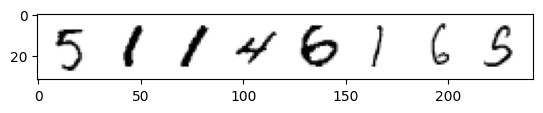

In [ ]:
# Load the dataset
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

### function for blurring the input image

In [ ]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 9.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2  # OpenCV for image blurring

# Function to create a blurred version of an image
def blur_image(image, kernel_size=3):
    image_np = image.numpy().squeeze()  # Convert to numpy
    blurred_np = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), 0)
    return torch.tensor(blurred_np).unsqueeze(0)  # Convert back to tensor


def bilateral_smooth(image, d=9, sigma_color=75, sigma_space=75):
    """
    Apply bilateral filtering to smooth the image while preserving edges.

    Parameters:
    - image: Input image tensor of shape (1, H, W).
    - d: Diameter of each pixel neighborhood.
    - sigma_color: Filter sigma in the color space.
    - sigma_space: Filter sigma in the coordinate space.

    Returns:
    - Smoothed image tensor of shape (1, H, W).
    """
    # Convert the PyTorch tensor to a NumPy array and remove the channel dimension
    image_np = image.squeeze().numpy()
    # Apply bilateral filter
    smoothed_np = cv2.bilateralFilter(image_np, d, sigma_color, sigma_space)
    # Convert back to a PyTorch tensor and add the channel dimension
    return torch.tensor(smoothed_np).unsqueeze(0)

def smooth_mean(image, kernel_size=5):
    """
    Apply mean (averaging) filtering to smooth the image.

    Parameters:
    - image: Input image tensor of shape (1, H, W).
    - kernel_size: Size of the averaging kernel.

    Returns:
    - Smoothed image tensor of shape (1, H, W).
    """
    image_np = image.numpy().squeeze()
    smoothed_np = cv2.blur(image_np, (kernel_size, kernel_size))  # Mean filtering
    return torch.tensor(smoothed_np).unsqueeze(0)


def smooth_gaussian(image, kernel_size=5, iterations=3):
    """
    Apply Gaussian blurring multiple times to smooth the image more aggressively.

    Parameters:
    - image: Input image tensor of shape (1, H, W).
    - kernel_size: Size of the Gaussian kernel.
    - iterations: Number of times to apply the blur.

    Returns:
    - Smoothed image tensor of shape (1, H, W).
    """
    image_np = image.cpu().numpy().squeeze()  # Move to CPU before converting
    for _ in range(iterations):  # Apply multiple blurring passes
        image_np = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), 0)
    return torch.tensor(image_np).unsqueeze(0).to(image.device)  # Convert back to tensor and move to original device

# import SimpleITK as sitk

# def smooth_recursive_gaussian(image, sigma=2.0):
#     """
#     Apply recursive Gaussian smoothing to the image.

#     Parameters:
#     - image: Input image tensor of shape (1, H, W).
#     - sigma: Strength of smoothing.

#     Returns:
#     - Smoothed image tensor of shape (1, H, W).
#     """
#     image_sitk = sitk.GetImageFromArray(image.numpy().squeeze())
#     smoothed_sitk = sitk.SmoothingRecursiveGaussian(image_sitk, sigma)
#     smoothed_np = sitk.GetArrayFromImage(smoothed_sitk)
#     return torch.tensor(smoothed_np).unsqueeze(0)



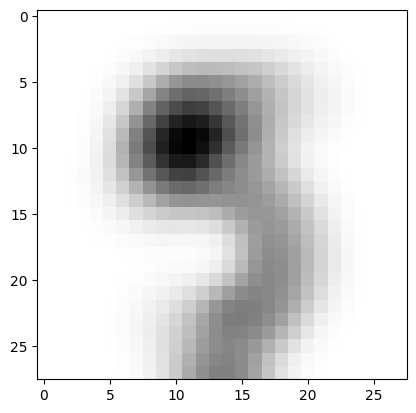

In [ ]:
# Blur the first image in the batch and display it
blurred_image = blur_image(x[0], 5)
smoothed_image = bilateral_smooth(blurred_image)
plt.imshow(smoothed_image.squeeze(), cmap='Greys');

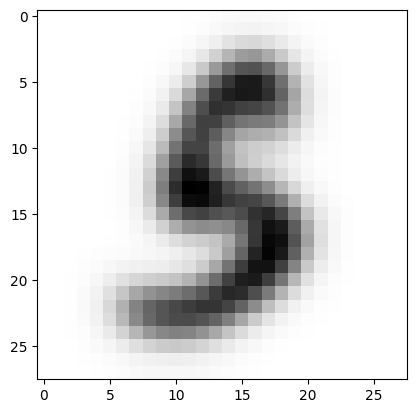

In [ ]:
# prompt: print a blurred image using above function

# Blur the first image in the batch and display it
# blurred_image = blur_image(x[0], 5)
x_7 = x[7] * 2 - 1
smoothed_image = smooth_gaussian(x_7, 5, 3)
plt.imshow(smoothed_image.cpu().squeeze(), cmap='Greys');


# blurred_image = blur_image(x[0], 11)
# plt.imshow(blurred_image.squeeze(), cmap='Greys');

In [ ]:
print(x_7.min().item(), x_7.max().item())
print(smoothed_image.min().item(), smoothed_image.max().item())

-1.0 1.0
-1.0 -0.04967515170574188


## Creating a Class-Conditioned UNet

The way we'll feed in the class conditioning is as follows:
- Create a standard `UNet2DModel` with some additional input channels  
- Map the class label to a learned vector of shape `(class_emb_size)`via an embedding layer
- Concatenate this information as extra channels for the internal UNet input with `net_input = torch.cat((x, class_cond), 1)`
- Feed this `net_input` (which has (`class_emb_size+1`) channels in total) into the UNet to get the final prediction

In this example I've set the class_emb_size to 4, but this is completely arbitrary and you could explore having it size 1 (to see if it still works), size 10 (to match the number of classes), or replacing the learned nn.Embedding with a simple one-hot encoding of the class label directly.

This is what the implementation looks like:

In [ ]:
class ClassConditionedUnet(nn.Module):
  def __init__(self):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    # self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=2, # Additional input channel for blurred image
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, blurred_x):


    x_combined = torch.cat((x, blurred_x), dim=1)  # Concatenate original and blurred image (bs, 2, 28, 28)
    return self.model(x_combined, t).sample # (bs, 1, 28, 28)


    # # Shape of x:
    # bs, ch, w, h = x.shape

    # # class conditioning in right shape to add as additional input channels
    # class_cond = self.class_emb(class_labels) # Map to embedding dimension
    # class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # # Net input is now x and class cond concatenated together along dimension 1
    # net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # # Feed this to the UNet alongside the timestep and return the prediction
    # return self.model(net_input, t).sample # (bs, 1, 28, 28)

If any of the shapes or transforms are confusing, add in print statements to show the relevant shapes and check that they match your expectations. I've also annotated the shapes of some intermediate variables in the hopes of making things clearer.

## Training and Sampling

Where previously we'd do something like `prediction = unet(x, t)` we'll now add the correct labels as a third argument (`prediction = unet(x, t, y)`) during training, and at inference we can pass whatever labels we want and if all goes well the model should generate images that match. `y` in this case is the labels of the MNIST digits, with values from 0 to 9.

The training loop is very similar to the [example from Unit 1](https://github.com/huggingface/diffusion-models-class/blob/unit2/unit1/02_diffusion_models_from_scratch.ipynb). We're now predicting the noise (rather than the denoised image as in Unit 1) to match the objective expected by the default DDPMScheduler which we're using to add noise during training and to generate samples at inference time. Training takes a while - speeding this up could be a fun mini-project, but most of you can probably just skim the code (and indeed this whole notebook) without running it since we're just illustrating an idea.

In [ ]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.035438


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.028965


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.025831


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.023532


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.023012


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.021713


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.021032


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.019695


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.020147


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.019702


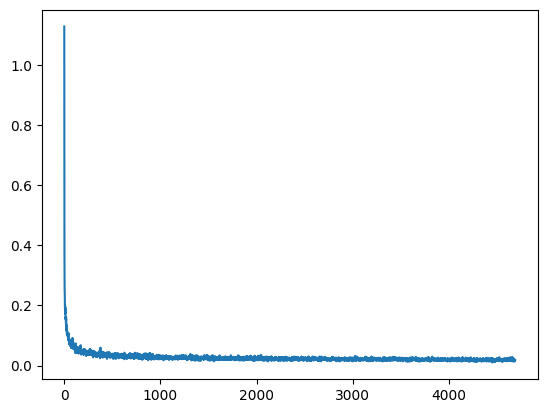

In [ ]:
#@markdown Training loop (10 Epochs):

# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)

        blurred_x = torch.stack([smooth_gaussian(img,5,5) for img in x])
        blurred_x = blurred_x.to(device)

        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, blurred_x) # Note that we pass the blurred images instead of y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

Once training finishes, we can sample some images feeding in different labels as our conditioning:

In [ ]:
# Load the MNIST test dataset
mnist_test = torchvision.datasets.MNIST(root="mnist/", train=False, download=True,
                                        transform=torchvision.transforms.ToTensor())
# Load test dataset
test_loader = DataLoader(mnist_test, batch_size=256, shuffle=True)  # Larger batch to ensure all labels exist
test_images, test_labels = next(iter(test_loader))  # Get a batch of images and labels


torch.Size([80, 1, 28, 28])
torch.Size([80, 1, 28, 28])
0.0 0.919823408126831
-1.0 0.8396468162536621


0it [00:00, ?it/s]

(np.float64(-0.5), np.float64(241.5), np.float64(301.5), np.float64(-0.5))

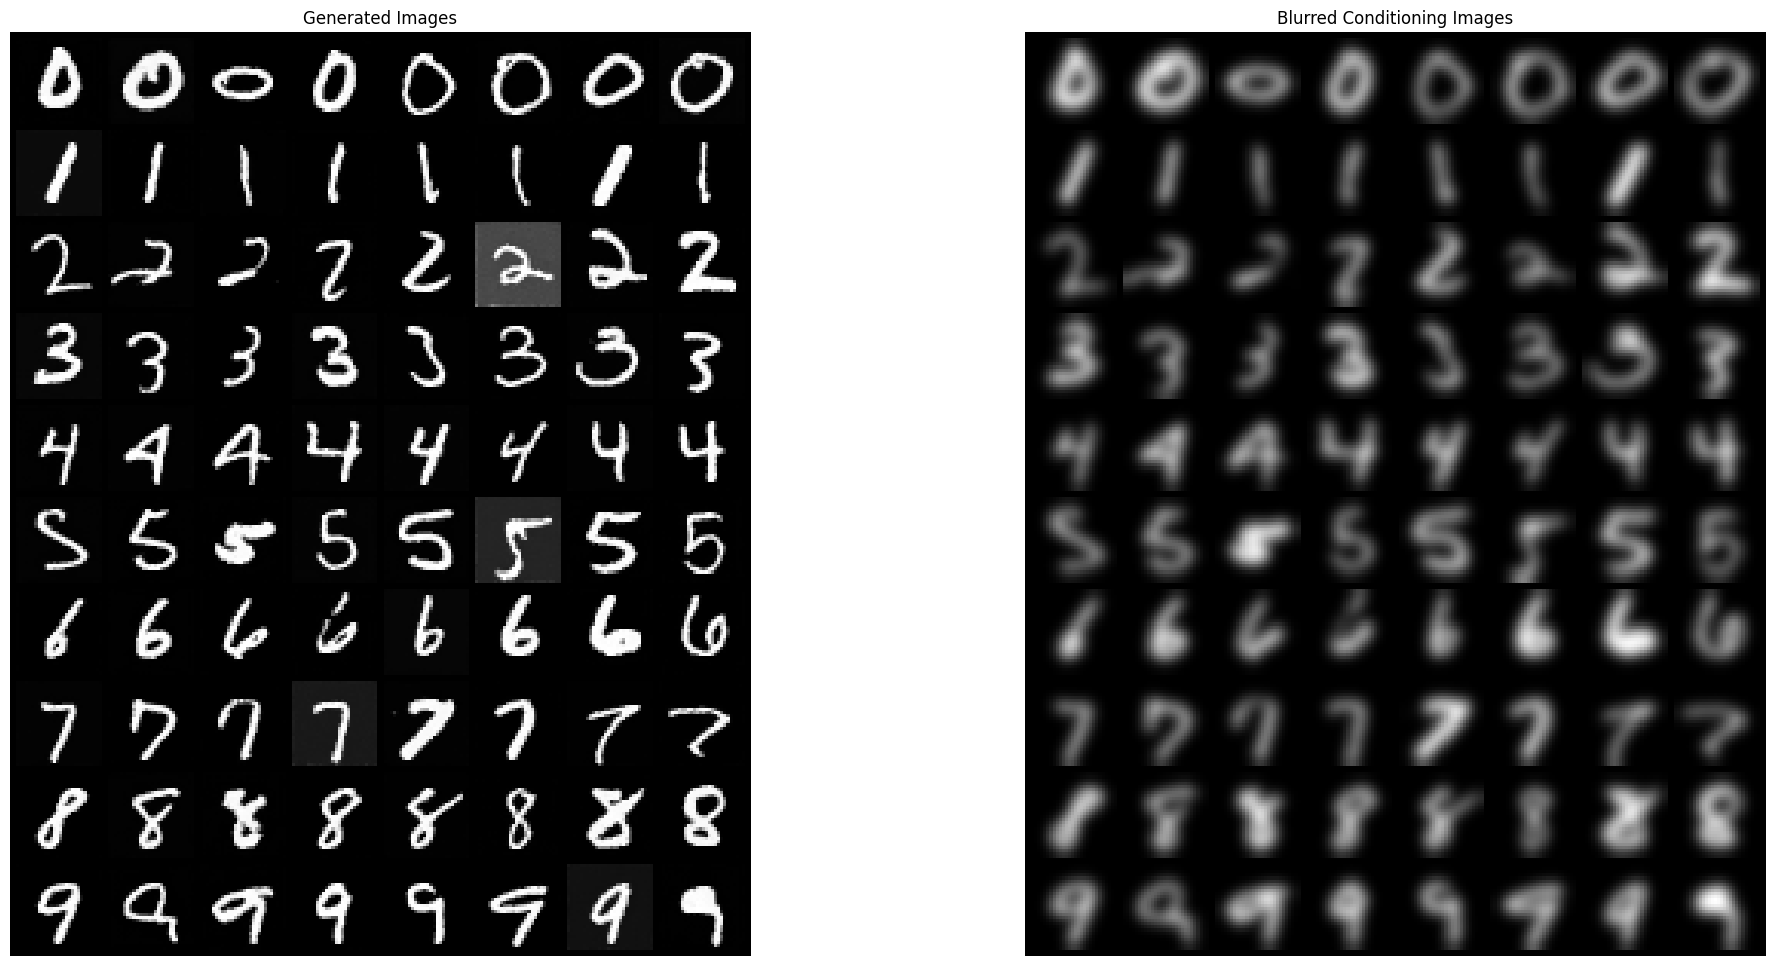

In [ ]:
#@markdown Sampling some different digits:

# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten()

# Move data to device
test_images = test_images
test_labels = test_labels

# Select images corresponding to y (ensuring the order matches)
selected_images = []
# Iterate over labels 0 to 9
for label in range(10):
    # Get all indices where the test label matches the current label
    indices = (test_labels == label).nonzero(as_tuple=True)[0]
    # Shuffle and take 8 indices (or take the first 8 if order doesn't matter)
    selected = indices[torch.randperm(len(indices))][:8]
    # Append the corresponding images
    for idx in selected:
        selected_images.append(test_images[idx])

selected_images = torch.stack(selected_images)  # Shape will be (80, 1, 28, 28)

blurred_x = torch.stack([smooth_gaussian(img,5,5) for img in selected_images])  # Blur them
print(blurred_x.shape)
print(x.shape)
print(blurred_x.min().item(), blurred_x.max().item())
blurred_x = blurred_x.to(device) * 2 - 1
print(blurred_x.min().item(), blurred_x.max().item())
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    # t = t.expand(x.shape[0])  # Ensure `t` matches batch size (80)

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, blurred_x)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Convert tensors to grid format for visualization
generated_grid = torchvision.utils.make_grid(x.detach().cpu(), nrow=8, normalize=True)
blurred_grid = torchvision.utils.make_grid(blurred_x.detach().cpu(), nrow=8, normalize=True)

# Create figure and show images
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Show generated images
axes[0].imshow(generated_grid.permute(1, 2, 0), cmap='Greys')
axes[0].set_title("Generated Images")
axes[0].axis("off")

# Show blurred conditioning images
axes[1].imshow(blurred_grid.permute(1, 2, 0), cmap='Greys')
axes[1].set_title("Blurred Conditioning Images")
axes[1].axis("off")

Pixel value range before normalization: -0.7271201014518738 1.0


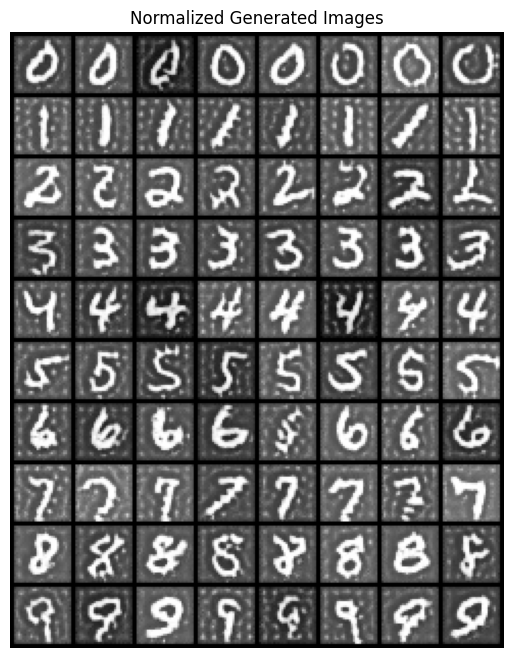

In [ ]:
# Detach, move to CPU, and clip values
x_cpu = x.detach().cpu().clip(-1, 1)

# Compute min and max pixel values from x_cpu
min_val = x_cpu.min().item()
max_val = x_cpu.max().item()
print("Pixel value range before normalization:", min_val, max_val)

# Manually normalize x_cpu using the computed range
x_norm = (x_cpu - min_val) / (max_val - min_val)

# Scale to the range [0, 255]
x_scaled = x_norm * 255

# Optionally, convert to uint8 if you prefer
x_uint8 = x_scaled.to(torch.uint8)

# Generate grid without internal normalization
generated_grid = torchvision.utils.make_grid(x_uint8, nrow=8, normalize=False)

# Display the grid image
plt.figure(figsize=(8, 8))
plt.imshow(generated_grid.permute(1, 2, 0), cmap='Greys')
plt.title("Normalized Generated Images")
plt.axis("off")
plt.show()


There we go! We can now have some control over what images are produced.

I hope you've enjoyed this example. As always, feel free to ask questions in the Discord.

In [ ]:
# Exercise (optional): Try this with FashionMNIST. Tweak the learning rate, batch size and number of epochs.
# Can you get some decent-looking fashion images with less training time than the example above?